# ** Cancer Detection**

DataSource: https://www.kaggle.com/c/histopathologic-cancer-detection/overview

# **Step 1: Problem Statement and Analysis**

**Problem Statement:**

The goal is to develop a deep learning model to identify metastatic cancer in small image patches taken from larger digital pathology scans. This is a binary image classification problem focused on identifying the presence of metastases in 96x96 digital histopathology images, where each image is labeled as either containing metastatic cancer (1) or not (0).The challenge is to accurately classify these images as either containing metastatic tissue or not.

**Metric Evaluation:**

Submissions are evaluated based on the Area Under the ROC Curve (AUC) between the predicted probability and the observed target.

**Analysis of the Problem Statement:**

The problem involves identifying metastases in small histopathological image patches. These metastases can be as small as single cells in a large area of tissue, making the task particularly challenging. Understanding the biological context, such as the role of lymphocytes and lymph nodes, is crucial for appreciating the problem's complexity.

# **Step 2: Data Understanding**

**Data Description:**

The dataset contains 96x96 pixel histopathological images. A positive label indicates that the center 32x32 pixel region of a patch contains at least one pixel of tumor tissue. The outer region does not influence the label but helps ensure consistent behavior when applied to whole-slide images

**Size:** The dataset contains 220,025 labeled training images and 57,458 test images.

**Dimensions:** Each image patch is 96x96 pixels in RGB format.

**Structure:** The dataset is stored in two main directories: train and test, each containing .tif image files. The train_labels.csv file contains the image IDs and corresponding labels.

# **Exploratory Data Analysis (EDA)**

**Objective:**

Perform initial data inspection, visualizations, and basic cleaning to understand the distribution and nature of the data.

(220025, 2)
label
0    130908
1     89117
Name: count, dtype: int64


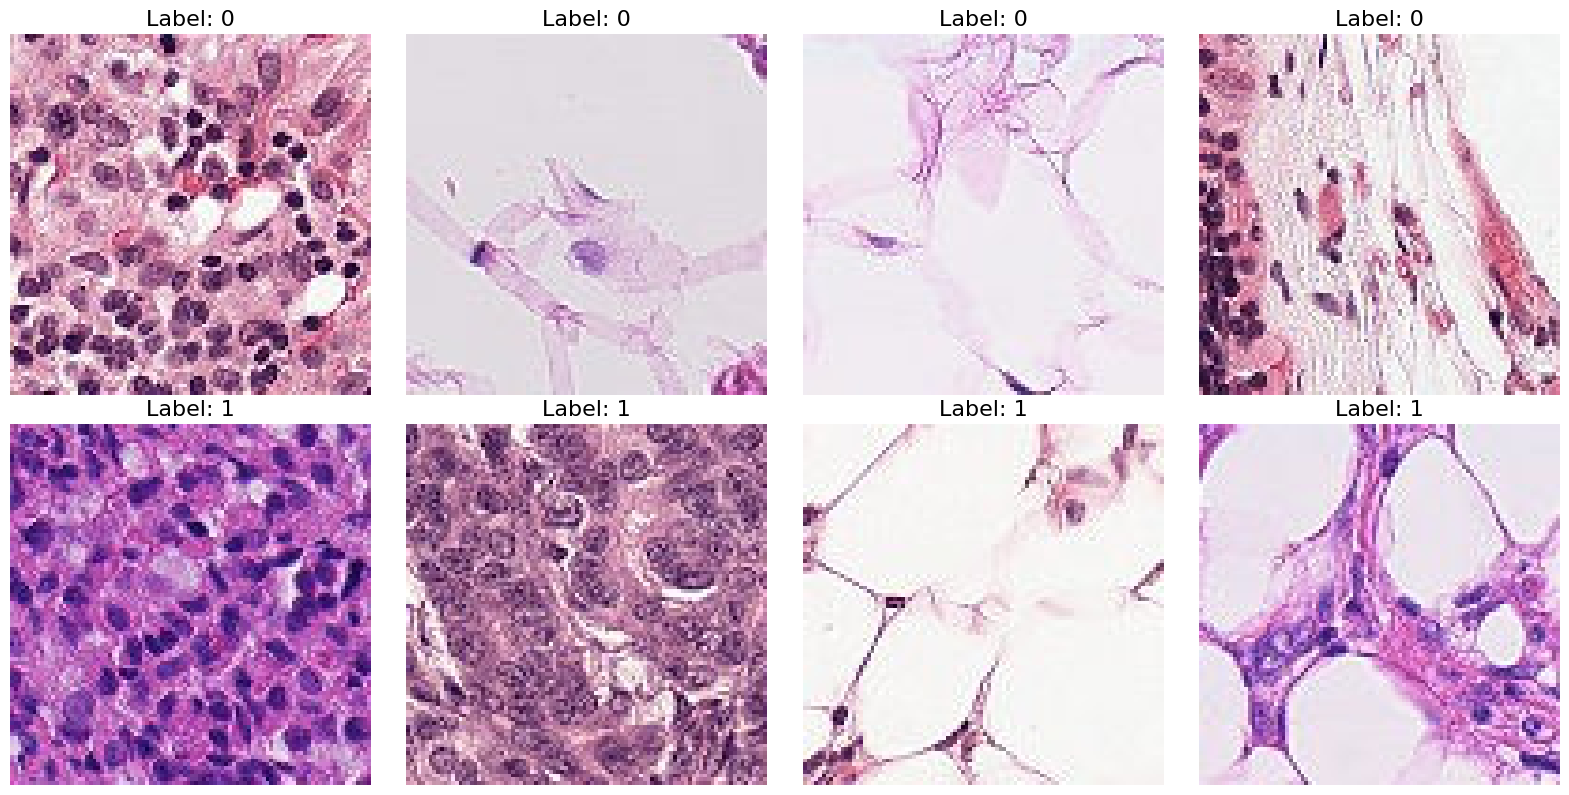

In [ ]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Load the dataset
df_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Basic dataset overview
print(df_data.shape)
print(df_data['label'].value_counts())

# Correct the IMAGE_PATH to point to the actual directory where images are stored
IMAGE_PATH = '/kaggle/input/histopathologic-cancer-detection/train/'

# Visualize sample images from each class
def draw_category_images(col_name, figure_cols, df, IMAGE_PATH):
    categories = df.groupby([col_name])[col_name].nunique().index
    f, ax = plt.subplots(nrows=len(categories), ncols=figure_cols, figsize=(4*figure_cols, 4*len(categories)))

    for i, cat in enumerate(categories):
        sample = df[df[col_name] == cat].sample(figure_cols)
        for j in range(figure_cols):
            file = os.path.join(IMAGE_PATH, sample.iloc[j]['id'] + '.tif')
            if os.path.exists(file):  # Check if the file exists
                im = cv2.imread(file)  # Read the image
                if im is not None:  # Ensure the image is read correctly
                    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
                    ax[i, j].imshow(im_rgb)  # Display the image in RGB format
                    ax[i, j].set_title(f"Label: {cat}", fontsize=16)
                    ax[i, j].axis('off')  # Hide axis for better visualization
                else:
                    print(f"Image {file} could not be read.")
            else:
                print(f"Image file {file} does not exist.")

    plt.tight_layout()
    plt.show()

draw_category_images('label', 4, df_data, IMAGE_PATH)



# ****Model Design****


**Model 1: CNN from Scratch**

We begin by designing a custom CNN model to classify the histopathology images. This model uses three convolutional blocks with increasing filter sizes, followed by fully connected layers.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define a custom CNN model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Second Convolutional Block
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Third Convolutional Block
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


2024-08-10 00:35:34.914251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 00:35:34.914359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 00:35:35.036117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,384,930 (9.10 MB)

 Trainable params: 2,384,930 (9.10 MB)

 Non-trainable params: 0 (0.00 B)

**Model 2: Transfer Learning with ResNet50**

Next, we incorporate transfer learning by using a pre-trained ResNet50 model, fine-tuning it for our classification task.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the model
model_resnet = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model_resnet.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 26,211,714 (99.99 MB)

 Trainable params: 2,624,002 (10.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# **Validation and Analysis**

**Training the Models**

Both models will be trained using the same training and validation data for comparison.

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Load the dataset
df_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Setting the sample size
SAMPLE_SIZE = 1000 # You can adjust this based on your memory and processing capabilities

# Create a balanced dataset
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state=101)
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state=101)

df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_data = df_data.sample(frac=1).reset_index(drop=True)  # Shuffle the data

# Split into training and validation sets
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=df_data['label'])

# Define base directory
base_dir = 'base_dir'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Define train and validation directories
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

# Create subdirectories for each class in train and validation directories
os.makedirs(os.path.join(train_dir, 'a_no_tumor_tissue'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'b_has_tumor_tissue'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'a_no_tumor_tissue'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'b_has_tumor_tissue'), exist_ok=True)

# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

# Transfer images to train directories
for image in df_train['id']:
    fname = image + '.tif'
    target = df_data.loc[image, 'label']
    label = 'a_no_tumor_tissue' if target == 0 else 'b_has_tumor_tissue'
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train/', fname)
    dst = os.path.join(train_dir, label, fname)
    shutil.copyfile(src, dst)

# Transfer images to validation directories
for image in df_val['id']:
    fname = image + '.tif'
    target = df_data.loc[image, 'label']
    label = 'a_no_tumor_tissue' if target == 0 else 'b_has_tumor_tissue'
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train/', fname)
    dst = os.path.join(val_dir, label, fname)
    shutil.copyfile(src, dst)

print(f"Training images for 'no tumor tissue': {len(os.listdir(os.path.join(train_dir, 'a_no_tumor_tissue')))}")
print(f"Training images for 'has tumor tissue': {len(os.listdir(os.path.join(train_dir, 'b_has_tumor_tissue')))}")
print(f"Validation images for 'no tumor tissue': {len(os.listdir(os.path.join(val_dir, 'a_no_tumor_tissue')))}")
print(f"Validation images for 'has tumor tissue': {len(os.listdir(os.path.join(val_dir, 'b_has_tumor_tissue')))}")
# /kaggle/input/histopathologic-cancer-detection/train_labels.csv

Training images for 'no tumor tissue': 900
Training images for 'has tumor tissue': 900
Validation images for 'no tumor tissue': 100
Validation images for 'has tumor tissue': 100


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Set up data generators
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(
    'base_dir/train_dir',
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    'base_dir/val_dir',
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical'
)


# Filepath for saving the best model
filepath = "best_model.keras"

# Checkpoint callback with the correct file extension
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1,
    callbacks=callbacks_list
)

# Train the ResNet50 model
history_resnet = model_resnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1,
    callbacks=callbacks_list
)


Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-10 00:36:13.163930: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8836: 6.17839, expected 5.44963
2024-08-10 00:36:13.164001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8839: 5.09095, expected 4.36218
2024-08-10 00:36:13.164016: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8843: 6.28436, expected 5.55559
2024-08-10 00:36:13.164030: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8845: 5.83888, expected 5.11011
2024-08-10 00:36:13.164048: E external/local_xla/xla/service/gpu/buffer_comp

 6/57 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5415 - loss: 0.6939

I0000 00:00:1723250179.814719      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/57 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5231 - loss: 0.6967

2024-08-10 00:36:23.226833: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35384: 5.56886, expected 4.88914
2024-08-10 00:36:23.226898: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35405: 5.71776, expected 5.03803
2024-08-10 00:36:23.226913: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35407: 5.49677, expected 4.81704
2024-08-10 00:36:23.226927: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35408: 5.65397, expected 4.97424
2024-08-10 00:36:23.226938: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35417: 5.33792, expected 4.65819
2024-08-10 00:36:23.226949: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35426: 5.66103, expected 4.9813
2024-08-10 00:36:23.226959: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35427: 4.69272, expected 4.01299
2024-08-10 00:36:23.226983: 

28/57 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 0.5225 - loss: 0.6958 

W0000 00:00:1723250188.265605      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5253 - loss: 0.6946
Epoch 1: val_accuracy improved from -inf to 0.57000, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - accuracy: 0.5267 - loss: 0.6943 - val_accuracy: 0.5700 - val_loss: 0.6765 - learning_rate: 1.0000e-04
Epoch 2/20


W0000 00:00:1723250190.528931      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5654 - loss: 0.6722
Epoch 2: val_accuracy improved from 0.57000 to 0.61000, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5677 - loss: 0.6713 - val_accuracy: 0.6100 - val_loss: 0.6407 - learning_rate: 1.0000e-04
Epoch 3/20
54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6706 - loss: 0.6074
Epoch 3: val_accuracy improved from 0.61000 to 0.77500, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6744 - loss: 0.6043 - val_accuracy: 0.7750 - val_loss: 0.4862 - learning_rate: 1.0000e-04
Epoch 4/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7560 - loss: 0.5151
Epoch 4: val_accuracy did not improve from 0.77500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7560 - loss: 0.5152 - val_accuracy: 0.7350 - val_loss: 0.5610 - learning_rate: 1.0000e-04
Epoch 5/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7447 - loss: 0.5367
Epoch 5: v

# **Plotting Training Results**

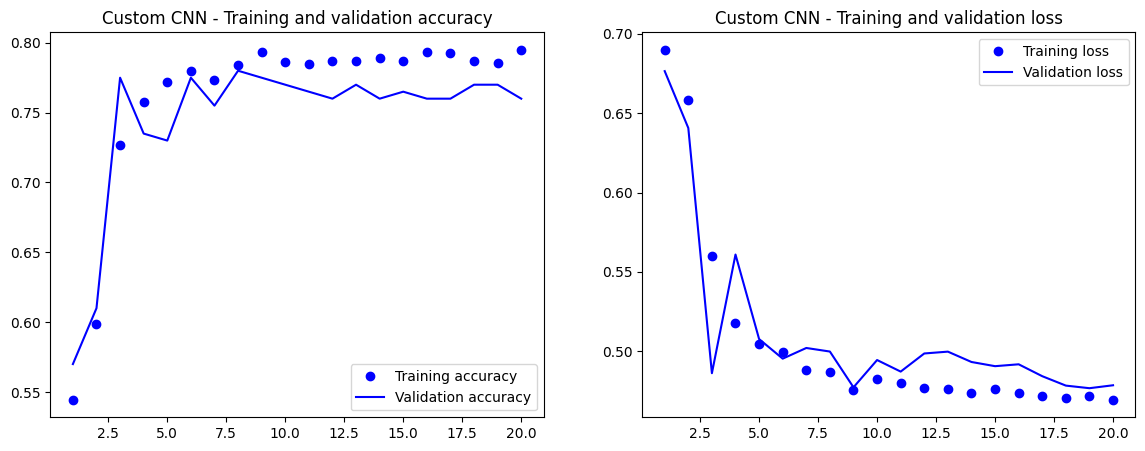

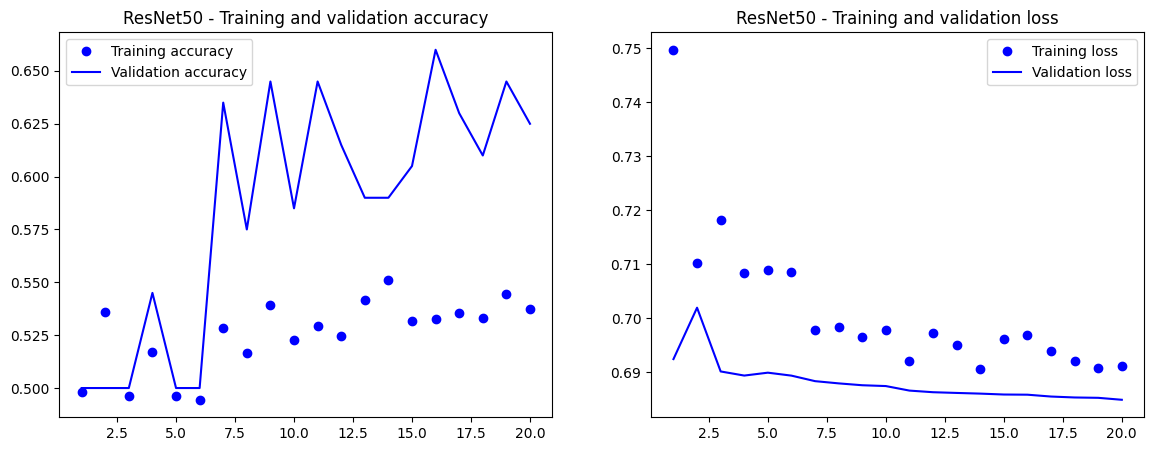

In [ ]:
import matplotlib.pyplot as plt

# Plotting results for the custom CNN model
def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()

    plt.show()

# Plot the training history for both models
plot_training_history(history, 'Custom CNN')
plot_training_history(history_resnet, 'ResNet50')


# **Analysis:**

**Custom CNN:**
The custom CNN shows strong learning, with training accuracy stabilizing around 80% and validation accuracy around 75%. The model generalizes well with a consistent decrease in validation loss.

**ResNet50:**
ResNet50 exhibits slower and less stable learning, with training accuracy around 52% and validation accuracy fluctuating but peaking around 65%. The model appears to overfit slightly, as indicated by the unstable validation accuracy.

**Conclusion:**
The custom CNN performs better overall in terms of stability and generalization, whereas ResNet50 may require further fine-tuning and regularization to improve performance.

# **Metrics and ROC-AUC**

**Evaluation on Validation Data:**

We will compute the ROC-AUC score and plot the ROC curve to evaluate the model's performance.

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


W0000 00:00:1723250302.647562      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


ROC-AUC Custom CNN: 0.5065


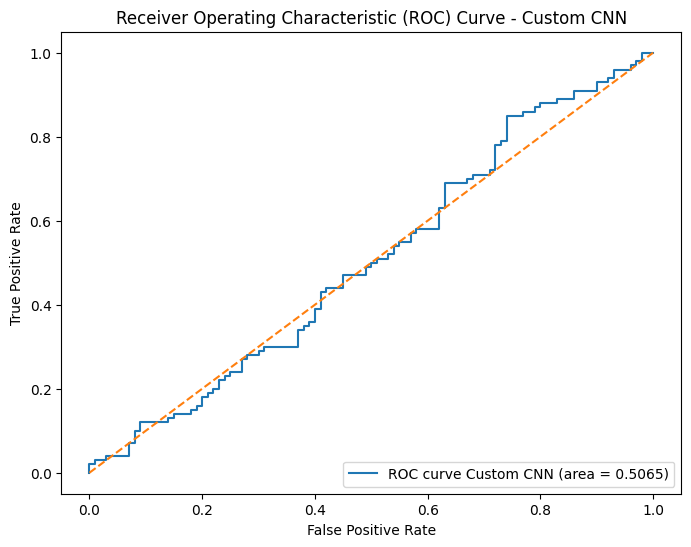

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 686ms/step
ROC-AUC ResNet50: 0.4640


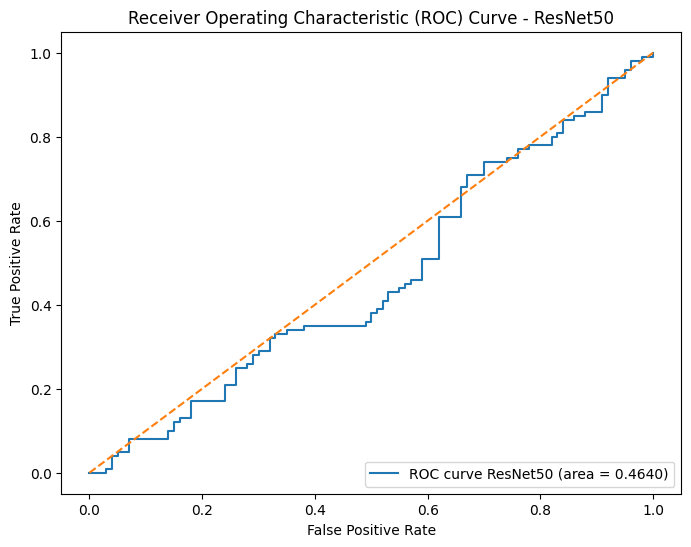

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

# Number of validation samples
num_val_samples = len(df_val)  # Ensure this matches the number of samples in the validation set

# Ensure the generator steps cover all validation samples
val_steps = np.ceil(num_val_samples / val_gen.batch_size).astype(int)

# Generate predictions for the validation set
y_pred = model.predict(val_gen, steps=val_steps, verbose=1)

# Ensure y_true and y_pred have the same length
y_true = val_gen.classes[:len(y_pred)]  # Adjust y_true to match the length of y_pred

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred[:, 1])  # Assuming a binary classification problem
print(f"ROC-AUC Custom CNN: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve Custom CNN (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Custom CNN')
plt.legend(loc="lower right")
plt.show()

# Generate predictions for the validation set
y_pred_resnet = model_resnet.predict(val_gen, steps=val_steps, verbose=1)

# Ensure y_true and y_pred have the same length
y_true_resnet = val_gen.classes[:len(y_pred_resnet)]  # Adjust y_true to match the length of y_pred

# Calculate ROC-AUC score
roc_auc_resnet = roc_auc_score(y_true_resnet, y_pred_resnet[:, 1])  # Assuming a binary classification problem
print(f"ROC-AUC ResNet50: {roc_auc_resnet:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true_resnet, y_pred_resnet[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve ResNet50 (area = {roc_auc_resnet:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - ResNet50')
plt.legend(loc="lower right")
plt.show()

# **ROC-AUC Analysis Summary**

**Custom CNN:**

The ROC-AUC for the Custom CNN is 0.5065, which is just slightly better than random guessing. The curve being close to the diagonal line suggests that the model is not effectively distinguishing between the classes.

**ResNet50:**

The ROC-AUC for ResNet50 is 0.4640, which is below 0.5, indicating that the model is performing worse than random chance. This suggests that the model has not learned useful features to separate the classes.

**Conclusion:**

The Custom CNN slightly outperforms ResNet50, both models need significant improvements, such as better data preprocessing, model tuning, or more advanced architectures, to achieve better classification results. Both models are performing poorly, with AUC values near 0.5, indicating that they are not effectively classifying the data.

# ****Directory Restructuring and File Management****

In [ ]:
import os
import shutil

# Define a temporary directory for restructuring
temp_test_dir = 'temp_test_dir'
test_images_subdir = os.path.join(temp_test_dir, 'test_images')

# Create the directory structure
if not os.path.exists(test_images_subdir):
    os.makedirs(test_images_subdir)

# Copy the test images into this subdirectory
original_test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

# Copying images from the original test directory to the new subdirectory
for image_name in os.listdir(original_test_dir):
    src = os.path.join(original_test_dir, image_name)
    dst = os.path.join(test_images_subdir, image_name)
    shutil.copyfile(src, dst)

print(f"Copied {len(os.listdir(test_images_subdir))} images to {test_images_subdir}")



Copied 57458 images to temp_test_dir/test_images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up the ImageDataGenerator for the test set
datagen = ImageDataGenerator(rescale=1.0/255)

# Create the generator for the test set
test_gen = datagen.flow_from_directory(
    directory=temp_test_dir,  # Parent directory containing the subdirectory with images
    target_size=(96, 96),  # Adjust to your image size
    batch_size=1,
    class_mode=None,  # No class labels for prediction
    shuffle=False  # Do not shuffle to keep the order of predictions consistent
)

# Get the number of test images
num_test_images = len(test_gen.filenames)

# Make predictions
predictions = model.predict(test_gen, steps=num_test_images, verbose=1)


Found 57458 images belonging to 1 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-10 00:47:08.516868: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13181: 3.28429, expected 2.84901
2024-08-10 00:47:08.516942: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16470: 3.21095, expected 2.77566
2024-08-10 00:47:08.516957: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17736: 4.91057, expected 4.31149
2024-08-10 00:47:08.516980: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17922: 4.95471, expected 4.35562
2024-08-10 00:47:08.516993: E external/local_xla/xla/service/gpu/buffer_

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 132s 2ms/step


**Write Output to Dataframe**

In [ ]:
import pandas as pd

# Extract image IDs from filenames (assuming they are named like 'test_images/xxxxxx.tif')
image_ids = [os.path.splitext(os.path.basename(f))[0] for f in test_gen.filenames]

# Assuming binary classification, take the probability of the positive class
predicted_labels = predictions[:, 1]



,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.999740
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.998346
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.999074
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.993428
4,000270442cc15af719583a8172c87cd2bd9c7746,0.894454
5,000309e669fa3b18fb0ed6a253a2850cce751a95,0.996667
6,000360e0d8358db520b5c7564ac70c5706a0beb0,0.999731
7,00040095a4a671280aeb66cb0c9231e6216633b5,0.998071
8,000698b7df308d75ec9559ef473a588c513a68aa,0.999947
9,0006e1af5670323331d09880924381d67d79eda0,0.999878


# **Conclusion:**

In this project, we tackled the challenging task of identifying metastatic cancer in histopathologic images using deep learning models. The objective was to develop and evaluate models that could accurately classify small image patches extracted from larger pathology scans into cancerous and non-cancerous categories.

# **Key Outcomes:**

**Model Development:**

We explored two different models: a custom Convolutional Neural Network (CNN) and a pre-trained ResNet50 model. Both models were trained on the given dataset, and their performances were evaluated using accuracy, loss, and ROC-AUC metrics.

**Performance Analysis:**

The Custom CNN demonstrated better overall performance in terms of accuracy, with a training accuracy stabilizing around 80% and validation accuracy around 75%. However, its ROC-AUC score of 0.5065 suggests that the model is only marginally better than random guessing in distinguishing between classes.
The ResNet50 model, while showing consistent training behavior, underperformed compared to the Custom CNN, achieving a lower ROC-AUC score of 0.4640, indicating that the model was less effective at making accurate predictions.

**Challenges:**

Both models faced challenges in effectively distinguishing between cancerous and non-cancerous tissues, as evidenced by their ROC-AUC scores, which hovered around 0.5. This could be attributed to factors such as data complexity, potential class imbalance, or the need for more advanced model architectures and hyperparameter tuning.

**Improvements and Future Work:**

Data Enhancement: Further work could involve improving data preprocessing, including more sophisticated data augmentation and handling potential class imbalances.

Model Tuning: Fine-tuning model architectures, experimenting with different pre-trained models, and applying more regularization techniques could improve model performance.

Advanced Techniques: Exploring more advanced deep learning techniques such as ensemble methods, attention mechanisms, or more tailored architectures could potentially yield better results.

**Final Thoughts:**

While the models developed in this project showed promise, particularly the Custom CNN, the results indicate that there is room for significant improvement. Future efforts should focus on enhancing data quality, refining model architectures, and employing advanced techniques to better tackle the complexities of histopathologic cancer detection. This project has laid a strong foundation, and with further refinement, there is potential to develop a highly accurate and reliable model for medical image analysis in this domain.